# Basic Training Scheme development notebook

## Importing section

In [1]:
import torch
from torch import optim, nn
from torch.utils.data import random_split, DataLoader
from etnn.data.ferris_wheel import load_pure_ferris_wheel_dataset
from etnn.data.tree_structure import TreeNode
from etnn.nn.layer_framework import ChiralLayerManagementFramework
from tqdm import tqdm
import matplotlib.pyplot as plt
from etnn.tools.training import train_epoch, eval_epoch
from etnn.tools.training_tools import EpochControl, ConfigStore, AccuracyManager

In [2]:
import numpy as np
import pandas as pd
import os

## Parameter definition

In [3]:
NUM_GONDOLAS = 10
NUM_PART_PG = 5
DATASET_SIZE = 10_000
DATASET_PATH = "../datasets"

In [4]:
val_perc = 0.1
test_perc = 0.2

In [5]:
SAVING_PATH = "."
MODEL_SAVING_NAME = "model.pt"

In [6]:
CONFIG_SAVING_NAME = "config.json"
ACCURACY_SAVING_NAME = "accuracies.csv"
RESULTS_FOLDER = "."

In [7]:
# todo: take care of None values as representing not yet implemented features
config = ConfigStore(
    in_dim=15,
    hidden_dim=32,
    out_dim=1,
    k=2,
    is_accuracy_score=False,
    which_score=None,
    loss_name=None,
    optimizer_name=None,
    num_max_epochs=20,
    learning_rate=0.001,
    batch_size=32,
    early_stop_tol=5,
    is_classification=False
)

## data preparation

In [8]:
dataset = load_pure_ferris_wheel_dataset(
    num_gondolas=NUM_GONDOLAS,
    num_part_pg=NUM_PART_PG,
    num_to_generate=DATASET_SIZE,
    dataset_path=DATASET_PATH
)

In [9]:
len(dataset)

10000

In [10]:
generator = torch.Generator().manual_seed(420)
train_ds, val_ds, test_ds = random_split(
    dataset,
    [1-val_perc-test_perc, val_perc, test_perc],
    generator=generator
)

In [11]:
train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=config.batch_size, shuffle=False)

In [12]:
# todo: add more tree mutated sequences that are in dataset
# todo: add some faulty sequences which disturb this and see how much this affects the training

## Build tree structure

In [13]:
tree_structure = TreeNode(
    node_type="C",
    children=[
        TreeNode("P", [TreeNode("E", NUM_PART_PG)])
        for _ in range(NUM_GONDOLAS)
    ]
)

## Define device

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
device

'cuda'

## Define Model

In [16]:
model = ChiralLayerManagementFramework(
    in_dim=config.in_dim,
    tree=tree_structure,
    hidden_dim=config.hidden_dim,
    out_dim=config.out_dim,
    k=config.k
).to(device)

## Define Loss and Optimizers

In [17]:
criterion = nn.MSELoss()

In [18]:
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)

## Training

In [19]:
# init loss history
loss_history_train = []
loss_history_test = []

In [20]:
epoch_control = EpochControl(
    model_save_name=MODEL_SAVING_NAME,
    config_save_name=CONFIG_SAVING_NAME,
    saving_folder_path=SAVING_PATH,
    tolerance=config.early_stop_tol,
    is_accuracy_score=config.is_accuracy_score
)

In [21]:
accuracy_protocoller = AccuracyManager(
    storage_name=ACCURACY_SAVING_NAME,
    storage_path=RESULTS_FOLDER,
    is_classification=False
)

In [22]:
# train for N epochs
for epoch in tqdm(range(config.num_max_epochs)):
    mean_train_loss, train_true_y, train_pred_y = train_epoch(
        model,
        train_loader,
        optimizer,
        device,
        criterion
    )

    loss_history_train += [mean_train_loss]

    mean_test_loss, test_true_y, test_pred_y = eval_epoch(
        model,
        test_loader,
        device,
        criterion
    )
    loss_history_test += [mean_test_loss]

    # use accuracy manager to calc accuracy metrics and save them
    accuracy_protocoller.calc_and_collect(
        config_id="t1",
        epoch=epoch+1,
        train_y_true=train_true_y,
        train_y_pred=train_pred_y,
        train_loss=mean_train_loss,
        test_y_true=test_true_y,
        test_y_pred=test_pred_y,
        test_loss=mean_test_loss,
    )

    # check if model is better and save it
    if epoch_control.retain_best_and_stop(model, mean_train_loss, mean_test_loss, config):
        break

  5%|▌         | 1/20 [00:06<02:08,  6.78s/it]

++save++


 35%|███▌      | 7/20 [00:43<01:22,  6.35s/it]

++save++


 60%|██████    | 12/20 [01:28<00:58,  7.37s/it]


In [23]:
pd.read_csv(os.path.join(SAVING_PATH, ACCURACY_SAVING_NAME))

,config_id,epoch,train_loss,val_loss,test_loss,train_mse,train_msa,val_mse,val_msa,test_mse,test_msa
0,t1,1,2048.504150,0.0,36.359035,2050.812012,14.197355,0.0,0.0,36.451962,4.781710
1,t1,2,39.551361,0.0,47.866241,39.540218,5.020311,0.0,0.0,47.975540,5.470905
2,t1,3,40.715530,0.0,43.749638,40.735943,5.079148,0.0,0.0,43.856499,5.215065
3,t1,4,40.643154,0.0,46.245281,40.646698,5.100926,0.0,0.0,46.353542,5.368684
4,t1,5,40.565376,0.0,38.639713,40.573723,5.093019,0.0,0.0,38.740688,4.897344
5,t1,6,41.575642,0.0,40.348053,41.580856,5.146065,0.0,0.0,40.432728,5.121716
6,t1,7,41.469261,0.0,36.107948,41.448669,5.156096,0.0,0.0,36.200245,4.766918
7,t1,8,39.815559,0.0,36.936600,39.824581,5.054956,0.0,0.0,37.024567,4.848920
8,t1,9,40.915134,0.0,36.911659,40.907856,5.124048,0.0,0.0,37.009132,4.793012
9,t1,10,42.473465,0.0,37.139339,42.490269,5.216657,0.0,0.0,37.225552,4.868730


In [24]:
loss_history_train

[tensor(2048.5042),
 tensor(39.5514),
 tensor(40.7155),
 tensor(40.6432),
 tensor(40.5654),
 tensor(41.5756),
 tensor(41.4693),
 tensor(39.8156),
 tensor(40.9151),
 tensor(42.4735),
 tensor(42.8895),
 tensor(41.4146),
 tensor(40.7740)]

In [25]:
loss_history_test

[tensor(36.3590),
 tensor(47.8662),
 tensor(43.7496),
 tensor(46.2453),
 tensor(38.6397),
 tensor(40.3481),
 tensor(36.1079),
 tensor(36.9366),
 tensor(36.9117),
 tensor(37.1393),
 tensor(36.3778),
 tensor(41.2976),
 tensor(36.1575)]

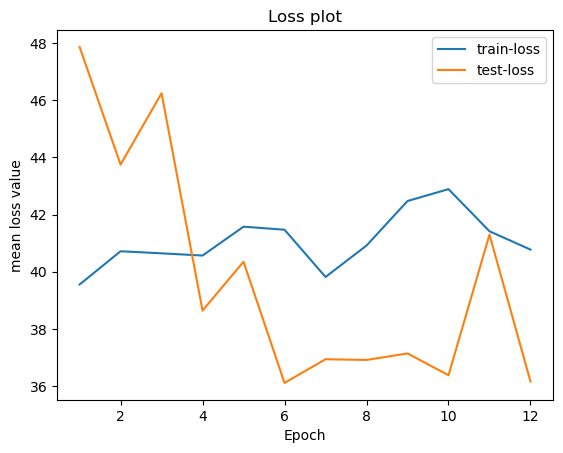

In [26]:
plt.figure()
idx = np.arange(len(loss_history_train))
offset = 1
plt.plot(idx[offset:], loss_history_train[offset:], label="train-loss")
plt.plot(idx[offset:], loss_history_test[offset:], label="test-loss")
plt.title("Loss plot")
plt.xlabel("Epoch")
plt.ylabel("mean loss value")
plt.legend()
plt.show()

In [27]:
test_loss = torch.nn.CrossEntropyLoss()

In [28]:
label = torch.tensor([0., 1.,2.,3.,4.])
pred = torch.tensor([1.1, 1., 2., 2., 4.])

In [29]:
test_loss(pred, label)

tensor(16.1880)

todo:
- build option for classification instead of regression
- either still predict number or make softmax classification

## Test/Debug

with open("test1.txt", "w") as file:
    file.write("config_id, epoch\n")
    file.write("0,1")

with open("test1.txt", "a") as file:
    file.write(f"\n")

import pandas as pd

pd.read_csv("test1.txt")

for x,y in train_loader:
    break

x.shape

x

y.shape

y

for i in range(1000):
    optimizer.zero_grad()
    prediction = model(x).flatten()
    loss = criterion(prediction, y)
    print(f"Epoch:{i+1} - loss:{loss}")
    loss.backward()
    optimizer.step()

y

model(x).flatten()